In [1]:
from class_SEIR import SEIR
import numpy as np
import matplotlib.pyplot as plt
import importlib
import sys
from scipy.integrate import odeint
from scipy.linalg import block_diag

In [2]:
def plot_all_states(S, E, I, R, dim):
    """
        dim: dimension of the mobility matrix
    
    """
    plt.subplot(2,2,1)
    #Plot all Susceptible
    for i in range(dim):
        plt.plot(S[i])

    plt.title("Susceptible")
    plt.ylabel("Person")

    plt.subplot(2,2,2)
    #Plot all Exposed
    for i in range(dim):
        plt.plot(E[i])

    plt.title("Exposed")  

    plt.subplot(2,2,3)
    #Plot all Infected
    for i in range(dim):
        plt.plot(I[i])

    plt.title("Infected")
    plt.ylabel("Person")
    plt.xlabel("Time")  

    plt.subplot(2,2,4)
    #Plot all Removed
    for i in range(dim):
        plt.plot(R[i])

    plt.title("Removed")
    plt.xlabel("Time")

    plt.show()

def plot_comparison(dim_system, test_syn, I_single, E_single, I0_sum, E0_sum):
    plt.rcParams["figure.figsize"] = 14, 10

    plt.subplot(2,2,1)
    for i in range(dim_system):
        plt.plot(t,test_syn.I[i][:-1], label='Infected nodes {}'.format(i))

    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.title("Infected, SEIR* model, {} nodes".format(dim_system))
    plt.legend()

    plt.subplot(2,2,2)
    for i in range(dim_system):
        plt.plot(t,test_syn.E[i][:-1], label='Exposed nodes {}'.format(i))

    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.title("Exposed, SEIR* model, {} nodes".format(dim_system))
    plt.legend()

    plt.subplot(2,2,3)
    plt.plot(t, I_single, label='Infected single')
    plt.plot(t, I0_sum[:-1], label='Infected sum {} nodes'.format(dim_system))
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.title("Infected, SEIR/SEIR* comparison")
    plt.legend()

    plt.subplot(2,2,4)
    plt.plot(t, E_single, label='Exposed single')
    plt.plot(t, E0_sum[:-1], label='Exposed sum {} nodes'.format(dim_system))
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.title("Exposed, SEIR/SEIR* comparison")
    plt.legend()

    plt.show()
    
#SEIR model function
def model_SEIR(y, t):
    S0 = y[0]
    E0 = y[1]
    I0 = y[2]
    R0 = y[3]
    N  = S0+E0+I0+R0
    dSdt = -beta * I0 * S0 /N
    dEdt = beta * I0 * S0 /N - sigma * E0 
    dIdt = sigma * E0  - (gamma * I0)
    dRdt = gamma * I0 
    return [dSdt, dEdt, dIdt, dRdt]

def mobility_matrix(dim_system, random_modulate=False, num_connected_nodes=None, diffusion=False, diff_value=None,
                    diagonal=False, symmetric=False, centralized=False, central_node=None, node_increment=None):
    """                 
    dim_system:  Integer 
                 Dimension of the mobility matrix
    random_modulate: Bool
                     matrix to set the number of connected nodes
    num_connected_nodes: Integer
                         Number of connected nodes in modulated matrix
    diffusion: Float
               Diffusion of the connected nodes. 0<diffusion<1
    diagonal:    Bool
                 Get a diagonal matrix
    symmetric:   Bool
                 Get a symmetric matrix
    centralized: Bool
                 Get a matrix with nodes with higher input mobility
    central_node: Array
                  Array of nodes that will receive a higher input
    node_increment: Double
                    Size that will be incremented the central nodes
    """
    if centralized:
        # random centralized mobility matrix
        P_syn        = np.random.rand(dim_system, dim_system)
        for i in central_node:
            P_syn[:,i]  *= node_increment                # multiply column i by node_increment
        P_syn        = P_syn/(P_syn.sum(1).reshape(-1,1)) 

    elif symmetric:
            # random symmetric matrix
            P_syn = np.random.rand(dim_system, dim_system)
            P_syn = P_syn/(P_syn.sum(1).reshape(-1,1))
            P_syn = (P_syn + P_syn.T)/2
            
    elif diagonal:
            # disconnected matrix, only diagonal values, ie only mobility in nodes
            P_syn = np.diag(np.repeat(1,dim_system))
            
    elif random_modulate:
            # random normalized matrix with only some nodes connected
            if num_connected_nodes<=1:
                print("Warning: Not connected nodes")
                
            # set diagonal with full population
            P_diag         = np.diag(np.repeat(1.0,dim_system))
            
            if diffusion==True:
                P_diag         = np.diag(np.repeat(0.0,dim_system))
                # Fill with diffusion the connected nodes
                for node_i in range(num_connected_nodes):
                    for node_j in range(num_connected_nodes):
                        if node_i != node_j:
                            
                            P_diag[node_i, node_j] = np.random.rand()#rand_ij
                            
                # replace zero value for one, to avoid zero division
                aux = P_diag.sum(1).reshape(-1,1)
                aux[aux==0]=1
                # Normalize the matrix
                P_syn = P_diag*diff_value/aux #(P_diag.sum(1).reshape(-1,1))
                P_syn = P_syn + (np.diag(np.repeat(1.0,dim_system)- P_syn.sum(1)))                
            else:
                # Fill randomly the connected nodes
                for node_i in range(num_connected_nodes):
                    for node_j in range(num_connected_nodes):
                        P_diag[node_i, node_j] = np.random.rand()
                        P_diag[node_j, node_i] = np.random.rand()
                # Normalize the matrix
                P_syn = P_diag/(P_diag.sum(1).reshape(-1,1))
                #print(P_syn)
        
    else:
            # random normalized mobility matrix
            P_syn = np.random.rand(dim_system, dim_system) # dim_system x dim_system matrix
            P_syn = P_syn/(P_syn.sum(1).reshape(-1,1))     # normalize the matrix, 1-> sum over rows

    def alpha_syn(t):
        return(np.ones([dim_system, dim_system])) #mobility in node
    
    return(P_syn)

## SEIR* model

We have that

$$\beta \hat{S}_i\sum_{j=1}^n\frac{{\hat P}_{ij}}{\hat{N}_j}\hat{I}_j=
\beta k_SS_i\sum_{j=1}^n\frac{P_{ij}\alpha_{ij}(t)}{(\sum_{k=1}^nP_{kj}\alpha_{kj}(t)N_k)}\sum_{l=1}^nP_{lj}\alpha_{lj}(t)I_l(\epsilon\kappa_S+(1-\epsilon)\kappa_I).$$

so the SEIR* system became 

\begin{equation}
    \begin{split}
\frac{dS_i}{dt} &= -\beta \hat{S}_i  \sum_{j=1}^n\frac{\hat{P}_{ij}}{{\hat{N}_j}}\hat{I}_j\\
\frac{dE_i}{dt} &= \beta \hat{S}_i  \sum_{j=1}^n\frac{\hat{ P}_{ij}}{{\hat{N}_j}}\hat{I}_j - \sigma E_i  \\
\frac{dI_i}{dt} &= \sigma E_i - \gamma I_i\\
\frac{dR_i}{dt} &= \gamma I_i\\
\label{SEIR*}
\end{split}
\end{equation}

# Playground

Section to test different modifications to the system:

- Random population vector
- Random infected vector
- Random matrix generator
- Random centrality matrix
- Day and night matrix (check)

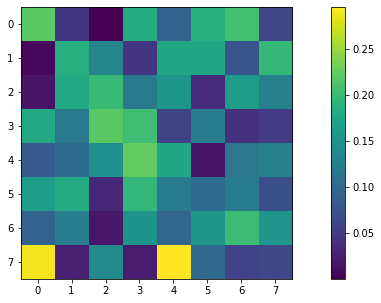

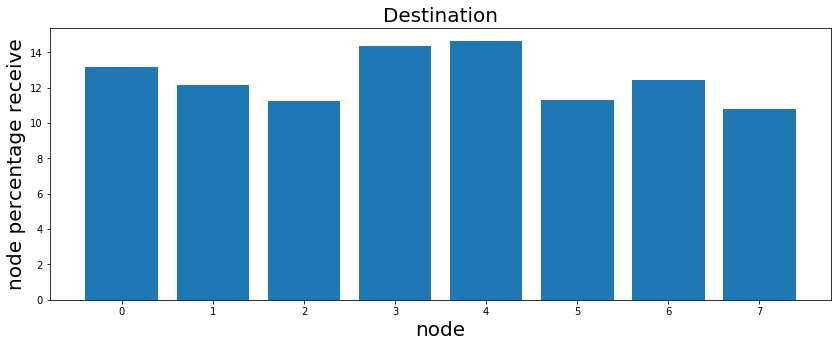

In [3]:
plt.rcParams["figure.figsize"] = 14, 5

dim_system = 8

# random normalized mobility matrix
P_syn = np.random.rand(dim_system, dim_system) # dim_system x dim_system matrix
P_syn = P_syn/(P_syn.sum(1).reshape(-1,1))     # normalize the matrix, 1-> sum over rows

# two block mobility matrix
"""
P_syn_a = np.random.rand(int(dim_system/2), int(dim_system/2))
P_syn_b = np.random.rand(int(dim_system/2), int(dim_system/2))
P_syn = block_diag(P_syn_a, P_syn_b)
P_syn[:,4]  += 1.8
P_syn = P_syn/(P_syn.sum(1).reshape(-1,1))
"""

# random centralized mobility matrix
"""
central_node  = [5, 8]
node_increase = 10

P_syn        = np.random.rand(dim_system, dim_system)
for i in central_node:
    P_syn[:,i]  *= node_increase                # multiply column i by node_increase
P_syn        = P_syn/(P_syn.sum(1).reshape(-1,1))    
"""

# random symetric matrix
#P_syn = np.random.rand(dim_system, dim_system)
#P_syn = P_syn/(P_syn.sum(1).reshape(-1,1))
#P_syn = (P_syn + P_syn.T)/2

# disconnected matrix, only diagonal values, ie only mobility in nodes
#P_syn = np.diag(np.repeat(1,dim_system))

# two connected nodes matrix
#P_syn = np.diag(np.repeat(0.5,5))
#P_syn[0][2] = 0.5
#P_syn[2][0] = 0.5

def alpha_syn(t): return(np.ones([dim_system, dim_system])) #mobility in node

plt.imshow(P_syn)
plt.colorbar()
plt.show()

plt.bar(np.arange(dim_system), P_syn.sum(0)*100/dim_system)
plt.title("Destination", size=20)
plt.xlabel("node", size=20)
plt.ylabel("node percentage receive", size=20) # mejorar descripcion
plt.show()

#plt.hist(P_syn)
#plt.xlabel("Probability")
#plt.show()

#P_syn

In [4]:
#initial conditions
t  = np.linspace(0, 400, 4000) # time grid, (from, to, number_of_step)

dim_system = len(P_syn)
#define initial states vector
S0 = np.full(dim_system,500) #10 dim array with 500 persons per square
E0 = np.zeros(dim_system)
I0 = np.zeros(dim_system)
R0 = np.zeros(dim_system)

I0[0] = 50 #50 initial infected persons in node 0

N = S0+E0+I0+R0

# alpha should have the same dimension than P_syn

# variables
beta  = 0.2
sigma = 0.1
gamma = 0.1
mu    = 1
#epsilon = 0.3 #from literature
epsilon = 1.0
ks = 1.0
ki = 1

#Init variables
tr=np.arange(401) #Days
h=0.1

print(N)

[550. 500. 500. 500. 500. 500. 500. 500.]


Initial condition 8 nodes
S0  100000.00000000003
I0  10.0
Scikit couldn't be imported. Using RK4 instead
Initial condition one node
S0  100000.00000000003
I0  10.0


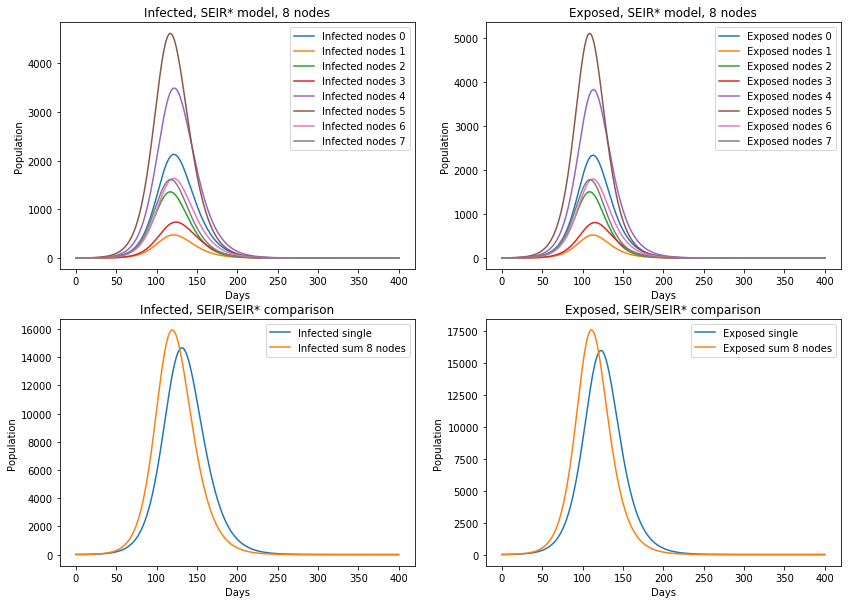

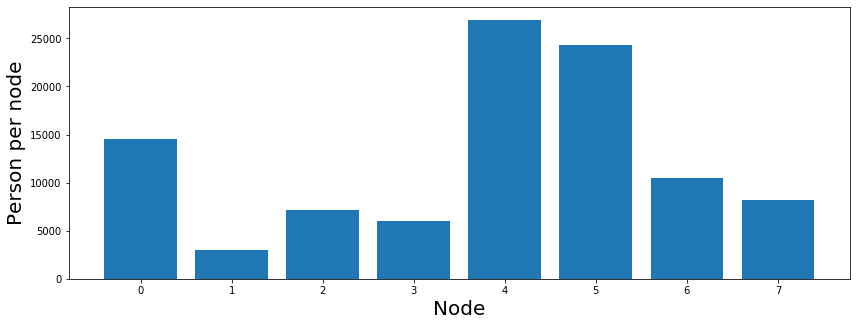

In [5]:
# variables
beta  = 0.3
sigma = 0.1
gamma = 0.1
mu    = 1
epsilon = 1.0
ks = 1.0
ki = 1

total_susceptible = 100000
total_infected    = 10

# random Susceptible vector
S0 = np.random.rand(dim_system)  # uniform random
#S0 = np.random.normal(30000, size = dim_system) # gaussian random
S0 = total_susceptible * S0/S0.sum()

#S0 = np.random.rand(10, 10)
#S0 = block_diag(S0, S0)

# zero values
E0 = np.zeros(dim_system)
R0 = np.zeros(dim_system)

# random infected vector
I0 = np.random.rand(dim_system)
I0 = total_infected * I0/I0.sum()
#I0 =  np.zeros(dim_system)
#I0[0] = 10

print("Initial condition {} nodes".format(dim_system))
print("S0 ",S0.sum())
print("I0 ",I0.sum())

#N = S0+E0+I0+R0 #not necessary, is inside SEIR class

test_syn = SEIR(P_syn,alpha_syn,S0, E0, I0, R0, 
                beta, sigma, gamma, mu, epsilon, ks, ki)

test_syn.integr(min(tr),max(tr),0.1, False)

# sum all states to compare with one node
S0_sum = 0
E0_sum = 0
I0_sum = 0
R0_sum = 0

for i in range(dim_system):
    S0_sum += test_syn.S[i]
    E0_sum += test_syn.E[i]
    I0_sum += test_syn.I[i]
    R0_sum += test_syn.R[i]

#### One node system ####
#initial conditions
t  = np.linspace(0, 400., 4000) # time grid, (from, to, number_of_step)
y0 = [S0.sum(), E0.sum(), I0.sum(), R0.sum()]
#N  = (S0.sum()+E0.sum()+I0.sum()+R0.sum())

print("Initial condition one node")
print("S0 ", S0.sum())
print("I0 ", I0.sum())
# solve the ODEs
soln = odeint(model_SEIR, y0, t) # (model, initial_conditions, time_series)

#reshape the output of the solver to plot the states
S_single = soln[:, 0]
E_single = soln[:, 1]
I_single = soln[:, 2]
R_single = soln[:, 3]

#plot
plot_comparison(dim_system, test_syn, I_single, E_single, I0_sum, E0_sum)

plt.rcParams["figure.figsize"] = 14, 5
plt.bar(np.arange(dim_system), (P_syn*S0).sum(0))
plt.xlabel("Node", size=20)
plt.ylabel("Person per node", size=20)
plt.show()

In [6]:
# 1 cuando hay mucha diferencia entre dinamicas de nodos el sistema ya no se puede sumar y obtener un gran SEIR,
# como es el caso de 2 nodos con una diferencia muy grande entre poblacion inicial.
# 2 Cuando hay uno nodo o un grupo de nodos que se dispara en contagio respecto a los otros, ya no es valido
# igualar un SEIR con un SEIR*, aunque la diferencia es baja.
# En otras palabras, cuando la entropia es alta, el sistema SEIR* se puede simplificar a un SEIR.

## Days divide in hours

In [33]:
#### One node system ####
#initial conditions
tdays  = np.linspace(0, 400., 4000) # time grid, (from, to, number_of_step)
y0 = [S0.sum(), E0.sum(), I0.sum(), R0.sum()]
#N  = (S0.sum()+E0.sum()+I0.sum()+R0.sum())

beta  = 0.2
sigma = 0.1
gamma = 0.1

print("Initial condition one node")
print("S0 ", S0.sum())
print("I0 ", I0.sum())
# solve the ODEs
soln = odeint(model_SEIR, y0, tdays) # (model, initial_conditions, time_series)

#reshape the output of the solver to plot the states
S_single = soln[:, 0]
E_single = soln[:, 1]
I_single = soln[:, 2]
R_single = soln[:, 3]

Initial condition one node
S0  100000.00000000003
I0  10.0


In [35]:
### 24 hours ###
#### One node system ####
#initial conditions
t24  = np.linspace(0, 9600., 96000) # 9600 = 400 days * 24 hours
y0 = [S0.sum(), E0.sum(), I0.sum(), R0.sum()]
#N  = (S0.sum()+E0.sum()+I0.sum()+R0.sum())

beta  = 0.2/24
sigma = 0.1/24
gamma = 0.1/24

print("Initial condition one node")
print("S0 ", S0.sum())
print("I0 ", I0.sum())
# solve the ODEs
soln = odeint(model_SEIR, y0, t24) # (model, initial_conditions, time_series)

#reshape the output of the solver to plot the states
S24_single = soln[:, 0]
E24_single = soln[:, 1]
I24_single = soln[:, 2]
R24_single = soln[:, 3]

Initial condition one node
S0  100000.00000000003
I0  10.0


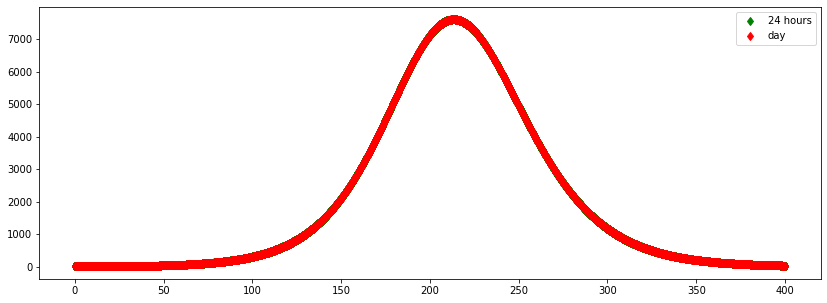

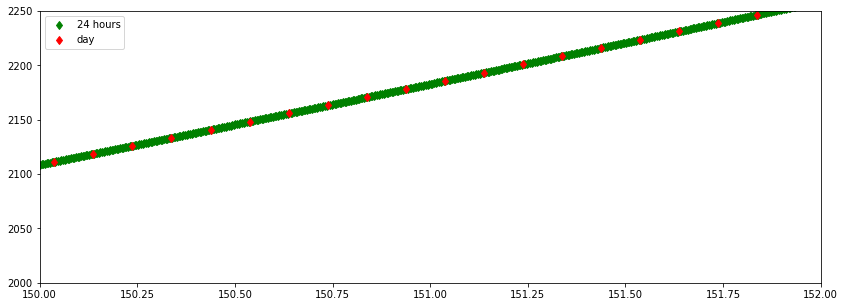

In [61]:
plt.plot(t24/24, I24_single, "gd", label="24 hours") # divide t24 by 24 and we get the curve in days
plt.plot(tdays, I_single, "rd",label="day")         # multiply days by 24 and we get the curve in hours
#plt.xlim(150, 152)
#plt.ylim(2000, 2250)
plt.legend()
plt.show()

# there is one red point each 24 green points

plt.plot(t24/24, I24_single, "gd", label="24 hours") # divide t24 by 24 and we get the curve in days
plt.plot(tdays, I_single, "rd",label="day")         # multiply days by 24 and we get the curve in hours
plt.xlim(150, 152)
plt.ylim(2000, 2250)
plt.legend()
plt.show()

In [48]:
print(len(I24_single))
print(len(I_single))

96000
4000
